In [1]:
!pip install imbalanced-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
import imblearn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Diabetes 130 US hospitals for years 1999-2008

Набор данных представляет сводку клинической помощи за 10 лет (1999-2008) в 130 больницах США и в интегрированных сетях оказания медицинской помощи.

In [3]:
url = 'https://raw.githubusercontent.com/TheSanchouz/diabetes_patient_readmission/main/diabetic_data.csv'
df = pd.read_csv(url)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Датасет состоит из 101 766 записей и 50 признаков

In [4]:
df.shape

(101766, 50)

Посмотрим на наш набор данных, отобразив первые 10 записей (для удобства транспонируем таблицу)

In [5]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type,NaN,Emergency,Emergency,Emergency,Emergency,Urgent,Elective,Emergency,Urgent,Elective
discharge_disposition,Not Mapped,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged/transferred to SNF
admission_source,Physician Referral,Emergency Room,Emergency Room,Emergency Room,Emergency Room,Clinic Referral,Clinic Referral,Emergency Room,Transfer from a hospital,Transfer from a hospital
time_in_hospital,1,3,2,2,1,3,4,5,13,12


Данные состоят из числовых, и категориальных признаков, также имеютcя пропущенные значения (NaN)

# Описание данных

## Входные признаки
*   **encounter_ID** [числовой]: уникальный идентификатор приема
*   **patient_number** [числовой]: уникальный идентификатор пациента
*   **race** [категориальный]: расовая принадлежность (Caucasian, Asian, African American, Hispanic и др.)
*   **gender** [категориальный]: пол
*   **age** [категориальный]: возраст, сгруппирован в 10-летние интервалы ([0, 10), [10, 20), ...)
*   **weight** [категориальный]: вес в фунтах, сгруппирован в 25-фунтовые интервалы ([0, 25), [25, 50), ...)
*   **admission_type** [категориальный]: тип обращения
*   **discharge_disposition** [категориальный]: расположение пациента на момент выписки
*   **admission_source** [категориальный]: источник направления для приема или посещения
*   **time_in_hospital** [числовой]: кол-во дней проведенных в больнице, между поступлением и выпиской
*   **payer_code** [категориальный]: код плательщика (кто или что покрывает медицинские расходы)
*   **medical_specialty** [категориальный]: медицинская специальность принимающего врача
*   **num_lab_procedures** [числовой]: число лабораторных тестов, проведенных во время посещения
*   **num_procedures** [числовой]: число процедур (кроме лаб.тестов), выполненных во время посещения
*   **num_medications** [числовой]: кол-во назначенных препаратов во время посещения
*   **number_outpatient** [числовой]: ко-во амбулаторных посещений пациента в год, предшествующих обращению
*   **number_emergency** [числовой]: кол-во обращений пациента за неотложной помощью в год, предшествующих обращению
*   **number_inpatient** [числовой]: кол-во стационарных посещений пациента в год, предшествующих обращению
*   **diag_1** [категориальный]: первичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **diag_2** [категориальный]: вторичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **diag_3** [категориальный]: дополнительный вторичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **number_diagnoses** [числовой]: число диагнозов, введенных в систему
*   **max_glu_serum** [категориальный]: диапазон результата теста на глюкозу в сыворотке кроки
*   **A1Cresult** [категориальный]: диапазон результата теста A1C
*   **metformin, ..., pioglitazone** [категориальный]: 23 различных лекарств; признак указывает, был ли препарат прописан или было изменение дозировки
*   **change** [категориальный]: указывает, было ли изменение лекарств от диабета (дозировка или препарат)
*   **diabetesMed** [категориальный]: указывает, были ли прописаны лекарства от диабета

## Выходной признак
*   **readmitted** [категориальный]: повторная госпитализация







# Постановка задачи

Важно знать, будет ли пациент повторно госпитализирован (реадмиссия, readmission).

В этой базе данных у нас есть 3 разных выхода:

*   нет реадмиссии [NO]
*   реадмиссия менее чем через 30 дней [<30] (это не лучшая ситуация, потому что, возможно, лечение не было подходящим)
*   реадмиссия более чем через 30 дней [>30] (эта не так хорошо, однако причиной может быть состояние пациента)

Показатели реадмиссии все чаще используются в качестве критерия результатов в исследованиях медицинских услуг и в качестве критерия качества для систем здравоохранения. Как правило, более высокая частота повторных госпитализаций указывает на неэффективность лечения во время прошлых госпитализаций.

# Анализ данных

Категоризуем признаки, имеющие тип 'object'

In [6]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type              object
discharge_disposition       object
admission_source            object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [7]:
for col in df.select_dtypes(['object']):
    df[col] = df[col].astype('category')

In [8]:
df.dtypes

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                      category
age                         category
weight                      category
admission_type              category
discharge_disposition       category
admission_source            category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
c

Удалим из наших данных признаки "encounter_id" и "patient_nbr", поскольку они являются только идентификаторами

In [9]:
df.drop(['patient_nbr', 'encounter_id'], axis=1, inplace=True)

Выведем количественную информацию про числовые признаки

In [10]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


И для категориальных признаков тоже

In [11]:
df.describe(include=['category'])

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,96475,98075,94985,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,7,25,16,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),Emergency,Discharged to home,Emergency Room,MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,53990,60234,57494,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


При анализе статистики категориальных признаков, можно заметить, что признаки "examide" и "citoglipton" состоят лишь из одного значения, а следовательно не несут какой-либо полезной информации, удалим их.



Также можно увидеть, что признаки "diag_1", "diag_2" и "diag_3" содержат большое кол-во уникальных значений (~750)

In [12]:
df.drop(['examide', 'citoglipton'], axis=1, inplace=True)

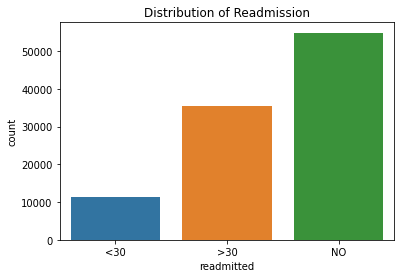

In [13]:
sns.countplot(x=df['readmitted']).set_title('Distribution of Readmission')
pass

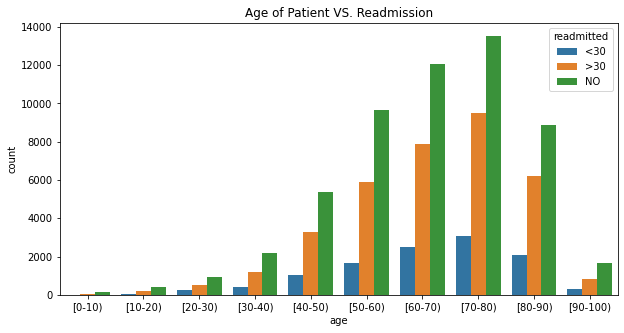

In [14]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(x=df['age'], hue=df['readmitted']).set_title('Age of Patient VS. Readmission')
pass

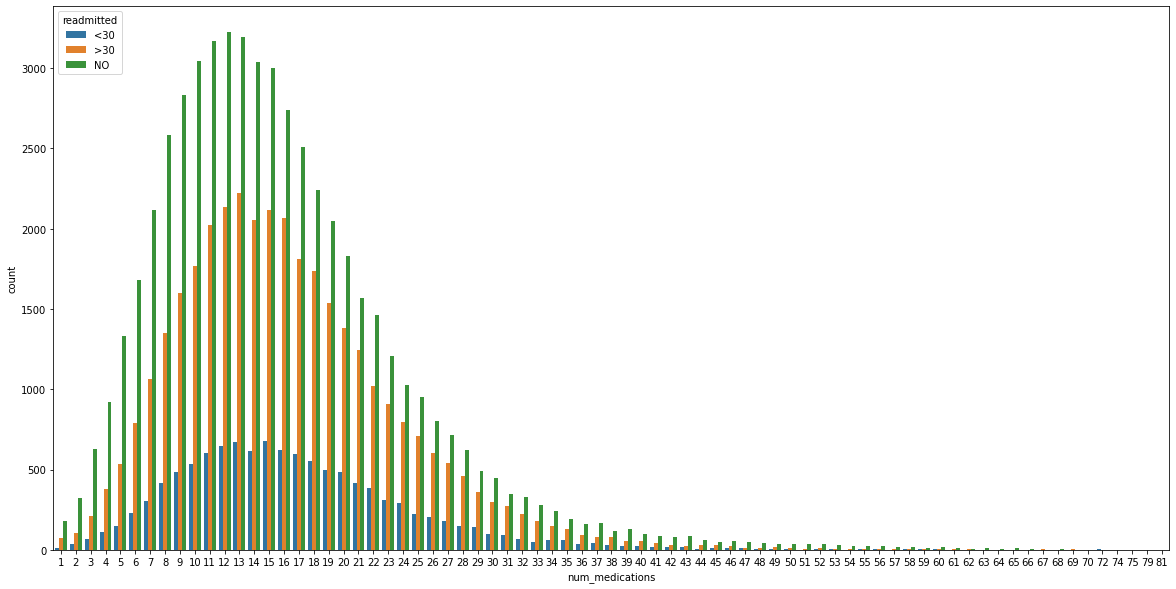

In [15]:
fig = plt.figure(figsize=(20, 10))
sns.countplot(x=df['num_medications'], hue=df['readmitted'])
pass

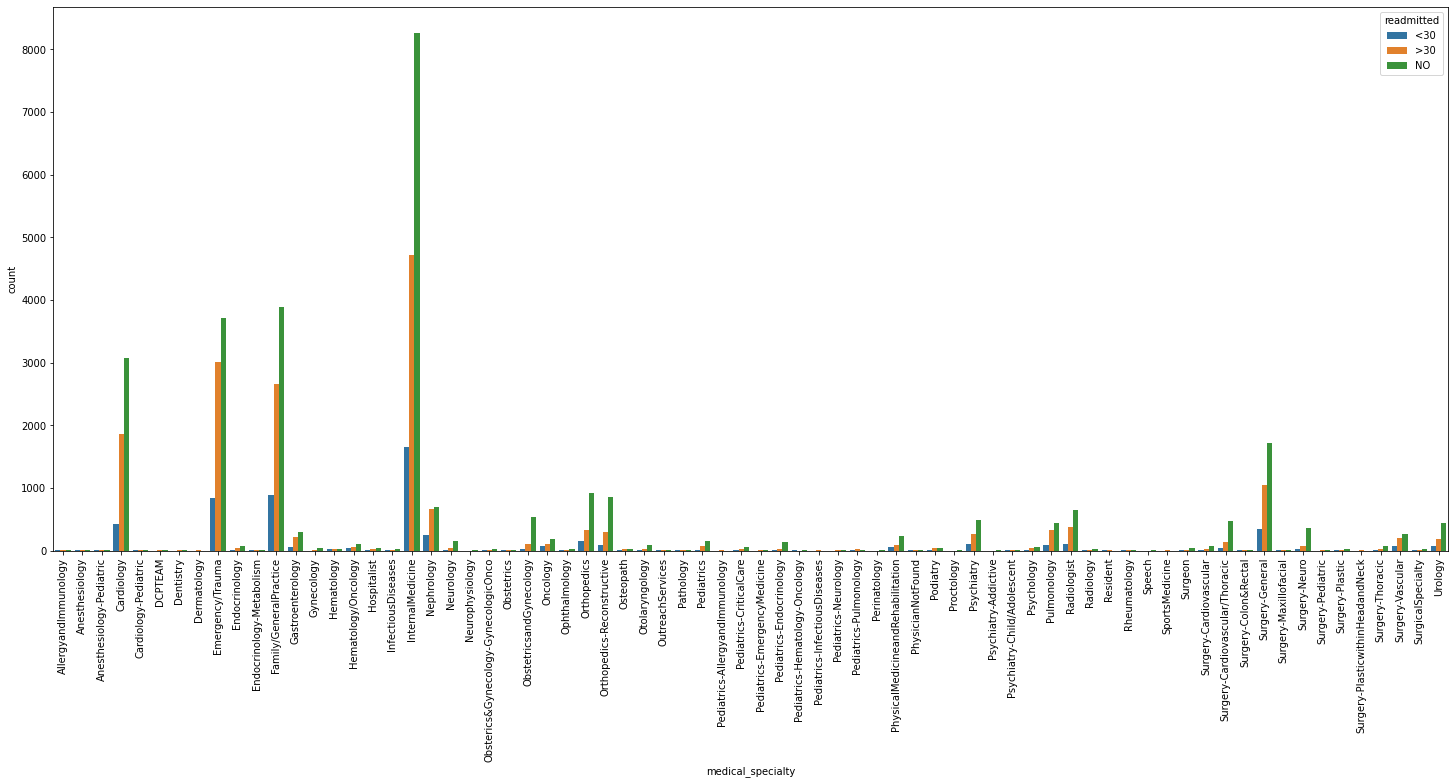

In [16]:
plt.figure(figsize=(25, 10))
chart = sns.countplot(x=df['medical_specialty'], hue=df['readmitted'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
pass

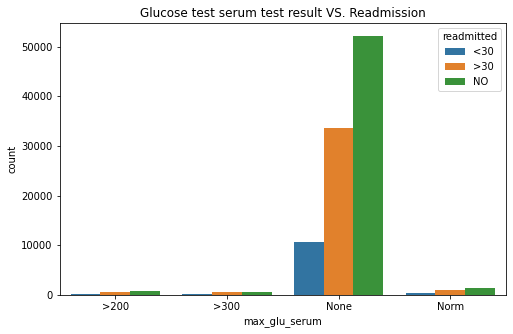

In [17]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(x=df['max_glu_serum'], hue=df['readmitted']).set_title('Glucose test serum test result VS. Readmission')
pass

Text(0.5, 1.0, 'A1C test result VS. Readmission')

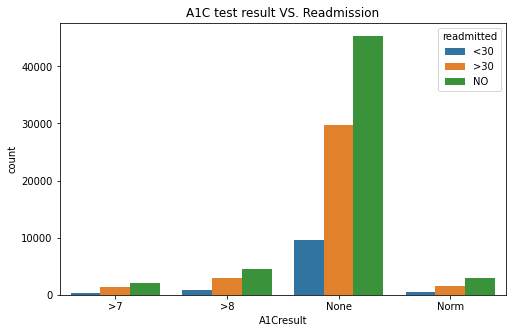

In [18]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(x=df['A1Cresult'], hue=df['readmitted']).set_title('A1C test result VS. Readmission')

Для того, чтобы получить матрицу корреляции и для числовых, и для категориальных признаков, произведем временную факторизацию категориальных данных

In [19]:
df_fact = df.copy()
for col in df_fact.select_dtypes(['category']):
    df_fact[col] = pd.factorize(df_fact[col])[0]

In [20]:
np.random.seed(6)
random_subset = np.random.choice(np.arange(df_fact.shape[0]), size=1000, replace=False)

In [21]:
# sns.pairplot(df_fact.iloc[random_subset], hue='readmitted', diag_kind='hist')
# plt.legend()
# pass

In [22]:
corr_mat = df_fact.corr(method='pearson')
corr_mat.style.background_gradient(cmap='coolwarm')

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
race,1.000000,-0.033583,-0.140272,-0.054619,-0.053243,-0.028658,0.003431,-0.006538,0.012574,0.002744,0.007778,-0.024318,-0.058253,-0.033018,0.024550,0.010202,0.017456,0.004511,0.003335,-0.067019,-0.012672,0.038841,-0.000173,-0.004275,0.008304,-0.001505,-0.018949,-0.001235,-0.004440,-0.022418,-0.005926,-0.010632,-0.007847,-0.006961,-0.002957,-0.002140,-0.003102,0.020972,-0.000861,-0.004455,-0.001235,-0.007670,-0.001235,0.004377,-0.003879,-0.010495
gender,-0.033583,1.000000,-0.050535,0.010623,0.006646,-0.019734,-0.017714,-0.029928,0.034695,0.014953,-0.003103,0.059980,-0.022023,-0.011481,-0.021081,-0.014643,-0.015656,-0.008582,-0.016728,-0.003407,-0.001777,0.014975,0.003090,-0.005157,-0.005047,0.003878,-0.001171,-0.002907,0.022951,0.028235,0.000477,0.004799,0.013438,0.012629,0.008527,0.005853,0.007279,-0.000923,0.003447,0.006954,-0.002907,0.004779,-0.002907,0.014905,0.015901,-0.014533
age,-0.140272,-0.050535,1.000000,-0.007005,0.001330,0.132850,0.023228,0.107515,-0.180412,-0.046885,0.020770,-0.030104,0.041847,0.023724,-0.087291,-0.042861,-0.059949,-0.062124,-0.058892,0.242597,0.046616,-0.117017,-0.055400,0.049578,0.016791,0.012677,0.036186,0.001776,0.052888,0.076182,0.011801,0.012911,0.002754,0.008556,0.011236,-0.001465,0.005199,-0.081905,-0.001293,0.002042,-0.000190,0.002512,-0.000190,-0.036019,-0.022601,0.030271
weight,-0.054619,0.010623,-0.007005,1.000000,-0.030567,-0.015864,-0.001394,0.018773,0.032643,-0.038246,0.075806,0.012259,0.007255,0.085127,0.005503,-0.009270,-0.002529,0.033069,0.020492,0.044758,-0.032692,-0.019878,0.015335,-0.004012,0.007169,0.000370,0.007423,-0.000463,0.014109,0.007546,-0.000912,0.022340,-0.001474,0.004974,-0.002618,-0.000801,-0.000922,-0.066217,-0.012037,-0.001668,-0.000463,-0.000654,-0.000463,-0.034539,-0.026571,0.023286
admission_type,-0.053243,0.006646,0.001330,-0.030567,1.000000,0.024666,-0.278199,-0.030338,0.044007,0.185197,-0.307261,0.114689,0.084065,0.061810,0.001738,-0.043576,0.031607,0.015855,0.011195,-0.047465,0.228200,-0.086639,0.029860,0.007025,0.000019,0.004233,0.006399,-0.001928,-0.006242,0.004237,0.008984,0.007476,0.020883,0.002780,0.001918,-0.004917,-0.004736,0.023676,0.016230,-0.002406,-0.001928,0.001137,0.003536,0.058241,0.034254,-0.038239
discharge_disposition,-0.028658,-0.019734,0.132850,-0.015864,0.024666,1.000000,-0.012004,0.133851,-0.008869,0.000277,0.034417,-0.013658,0.113407,0.018346,0.002683,0.028188,0.004350,0.021928,0.020968,0.116043,0.005534,-0.024213,-0.014551,0.009847,0.002954,-0.009170,0.001629,0.014849,0.002641,-0.015108,0.003027,0.006128,-0.000930,-0.002983,0.009015,-0.000194,-0.009269,0.038976,0.009034,0.001374,-0.001181,-0.000159,-0.000112,0.035717,0.019339,0.030499
admission_source,0.003431,-0.017714,0.023228,-0.001394,-0.278199,-0.012004,1.000000,0.060811,0.030930,-0.075583,0.158769,-0.043589,-0.057065,-0.075397,-0.016717,0.007384,-0.029678,-0.001092,-0.012278,-0.047441,-0.257989,0.053235,-0.023502,0.006950,-0.003525,0.005889,0.011598,0.000558,-0.008480,0.005591,-0.004187,-0.020946,-0.019097,-0.005067,0.001835,0.000966,0.003865,0.017638,-0.003425,-0.000271,0.000558,-0.001150,-0.002184,-0.037252,-0.000801,-0.028502
time_in_hospital,-0.006538,-0.029928,0.107515,0.018773,-0.030338,0.133851,0.060811,1.000000,-0.066288,-0.001539,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,-0.003928,0.033012,0.024733,0.220186,0.004254,0.062148,0.007128,0.032422,0.007098,0

Отобразим матрицу в компактном и красивом виде

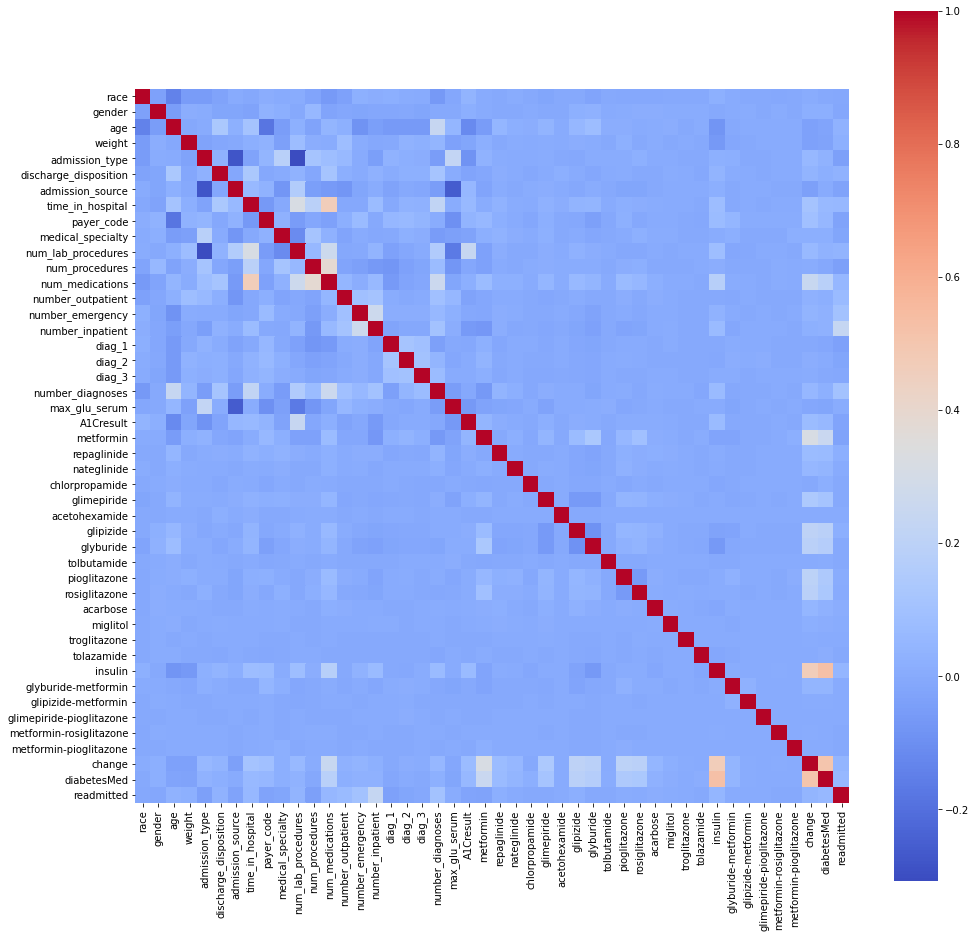

In [25]:
plt.figure(figsize=(16, 16))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

А также выведем те пары признаков, корреляция между которых > 0.4

In [ ]:
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)

insulin           diabetesMed        0.528238
change            diabetesMed        0.506370
insulin           change             0.468226
time_in_hospital  num_medications    0.466135
dtype: float64

Сильно коррелированные признаки отсутствует, существуют небольшие корреляции между "insulin", "change" и "diabetesMed", а также между "time_in_hospital" и "num_medications", которые вполне объяснимы

# Пропущенные и некорректные значения

Посмотрим, много ли пропущенных значений содержится в данном датасете

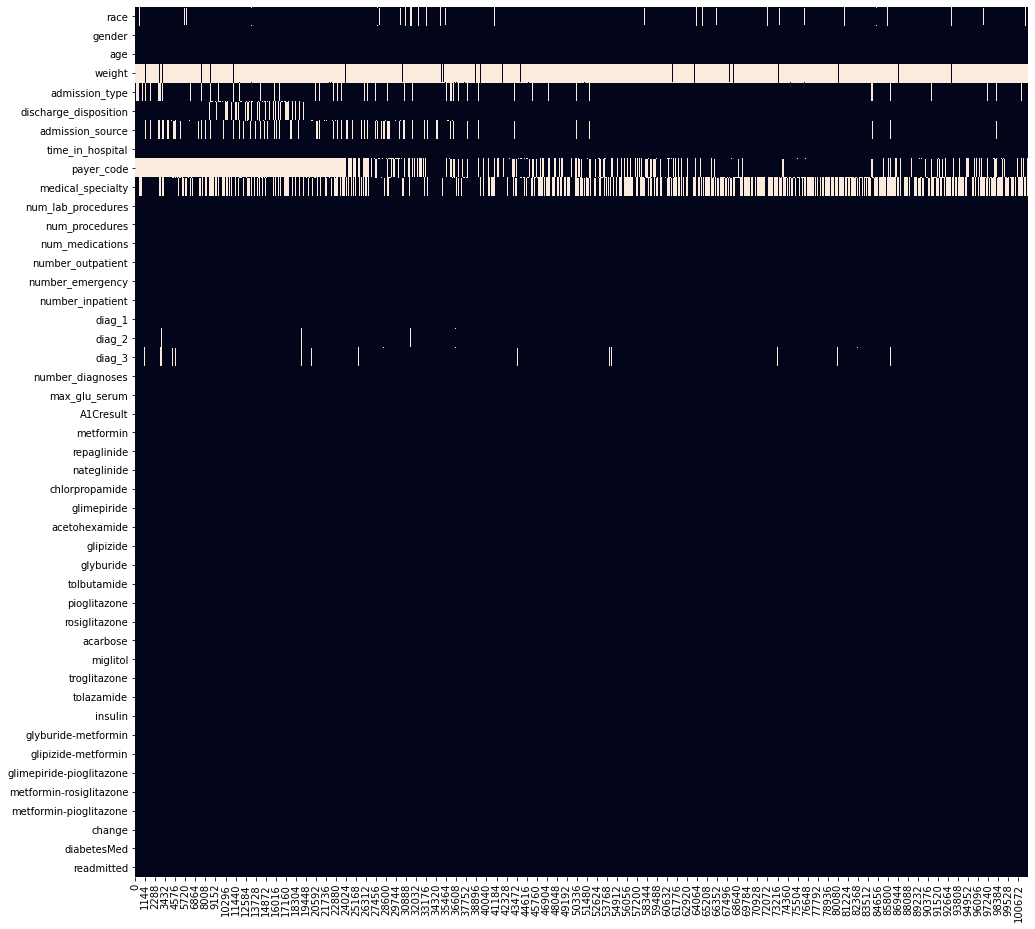

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.isnull().T, cbar=False)
pass

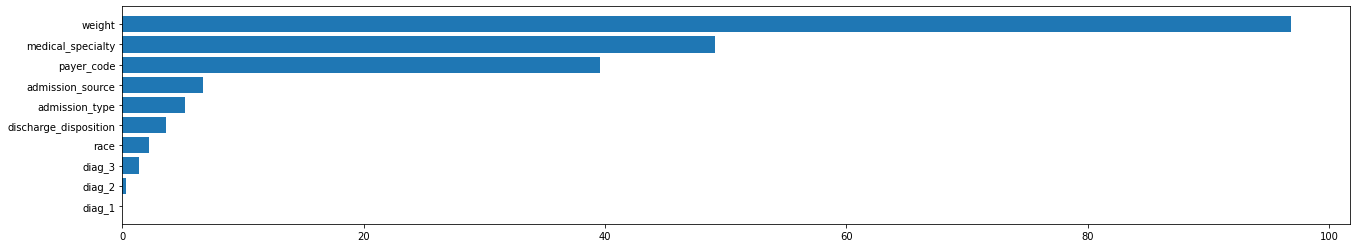

In [ ]:
plt.figure(figsize=(22, 4))
missing = pd.DataFrame({'column': df.columns, 'na_percent': (df.isnull().sum() / len(df)) * 100})
missing = missing[missing['na_percent'] != 0]
missing.sort_values('na_percent', inplace=True)
plt.barh(missing['column'], width=missing['na_percent'])
pass

Мы видим, что есть признаки, в которых пропущено много значений, а есть те, где незначительно

In [ ]:
missing['na_percent'].sort_values(ascending=False)

weight                   96.858479
medical_specialty        49.082208
payer_code               39.557416
admission_source          6.663326
admission_type            5.199182
discharge_disposition     3.626948
race                      2.233555
diag_3                    1.398306
diag_2                    0.351787
diag_1                    0.020636
Name: na_percent, dtype: float64

Также, изучим какие значения принимают категориальные признаки

In [ ]:
for cat_col in df.select_dtypes('category').columns.values.tolist():
    print(cat_col, df[cat_col].unique().tolist())

race ['Caucasian', 'AfricanAmerican', nan, 'Other', 'Asian', 'Hispanic']
gender ['Female', 'Male', 'Unknown/Invalid']
age ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
weight [nan, '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)', '[125-150)', '[175-200)', '[150-175)', '>200']
admission_type [nan, 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'Not Mapped', 'Trauma Center']
discharge_disposition ['Not Mapped', 'Discharged to home', 'Discharged/transferred to SNF', 'Discharged/transferred to home with home health service', 'Discharged/transferred to another short term hospital', 'Discharged/transferred to another type of inpatient care institution', 'Expired', 'Left AMA', 'Neonate discharged to another hospital for neonatal aftercare', 'Discharged/transferred to ICF', 'Hospice / medical facility', nan, 'Discharged/transferred to home under care of Home IV provider', 'Hospice / home', 'Still patient o

Удалим следующее признаки, потому что мы не сможем их восстановить:

*   "wieght" - отсутствует почти у всех записей
*   "medical_specialty" - отсутствует у половины записей
*   "payer_code" - отсутствует у почти 40% записей


In [ ]:
df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1, inplace=True)

Для следущих признаков заменим NaN'ы на значение 'Not Available' (данное значение специально выделено):

*   "admission_source"
*   "admission_type"
*   "discharge_disposition"

In [ ]:
df['admission_source'].fillna('Not Available', inplace=True)
df['admission_type'].fillna('Not Available', inplace=True)

df['discharge_disposition'].cat.add_categories('Not Available', inplace=True)
df['discharge_disposition'].fillna('Not Available', inplace=True)

Для остальных признаков, ввиду малости пропущенных значений, удалим те строки, содержащие NaN'ы:

*   "race"
*   "diag_3"
*   "diag_2"
*   "diag_1"

Возможно, диагнозы не были поставлены из-за сложности постановки конкретного диагноза (может быть диагноз не смогли установить или его не было)


In [ ]:
df.dropna(subset=['race', 'diag_3', 'diag_2', 'diag_1'], inplace=True)

Можно заметить, что признак "gender" содержит значение 'Unknown/Invalid', посмотрим, много ли таких в таблице

In [ ]:
len(df[df['gender'] == 'Unknown/Invalid'])

1

Таких значений очень мало, можем попросту удалить эти строки

In [ ]:
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, axis=0, inplace=True)

Проверим, нет ли больше пропущенных значений

In [ ]:
np.all(df.isnull().sum() == 0)

True

Таким способом мы потеряли 101766 - 98052 = 3714 записей и 50 - 43 = 7 признаков, что не много

In [ ]:
df.shape

(98052, 43)

## Категоризация болезней

Набор данных содержит до трех диагнозов для каждого пациента (первичный, вторичный и дополнительный). Однако у каждого из них 700–900 уникальных кодов МКБ9, что чрезвычайно сложно использовать в модели и интерпретировать.
Сгруппируем их в 9 категорий:

1.   Circulatory [390–459, 785]
2.   Respiratory [460–519, 786]
3.   Digestive [520–579, 787]
4.   Diabetes [250.xx]
5.   Injury [800–999]
6.   Musculoskeletal [710–739]
7.   Genitourinary [580–629, 788]
8.   Neoplasms [140–239]
9.   Other





In [ ]:
diagnoses = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury', 'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
diag_cols = ['diag_1', 'diag_2', 'diag_3']

df_diag_cat = df[diag_cols].copy()
df_diag_cat['diag_1'].cat.add_categories(diagnoses, inplace=True)
df_diag_cat['diag_2'].cat.add_categories(diagnoses, inplace=True)
df_diag_cat['diag_3'].cat.add_categories(diagnoses, inplace=True)

In [ ]:
def get_category_diag(code: str):
    if isinstance(code, float):
        return float('nan')

    if code.startswith('V') or code.startswith('E'):
        return 'Other'

    code = float(code)
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    if 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    if 520 <= code <= 579 or code == 787:
        return 'Digestive'
    if int(code) == 250:
        return 'Diabetes'
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    if 140 <= code <= 239:
        return 'Neoplasms'
  
    return 'Other'

for index, row in df.iterrows():
    df_diag_cat.loc[index, 'diag_1'] = get_category_diag(df.loc[index, 'diag_1'])
    df_diag_cat.loc[index, 'diag_2'] = get_category_diag(df.loc[index, 'diag_2'])
    df_diag_cat.loc[index, 'diag_3'] = get_category_diag(df.loc[index, 'diag_3'])

In [ ]:
df_diag_cat

,diag_1,diag_2,diag_3
1,Other,Diabetes,Other
2,Other,Diabetes,Other
3,Other,Diabetes,Circulatory
4,Neoplasms,Neoplasms,Diabetes
5,Circulatory,Circulatory,Diabetes
...,...,...,...
101761,Diabetes,Other,Circulatory
101762,Digestive,Other,Digestive
101763,Other,Genitourinary,Other
101764,Injury,Other,Injury


In [ ]:
df_diag_cat['diag_3'].unique().tolist()

['Other',
 'Circulatory',
 'Diabetes',
 'Respiratory',
 'Injury',
 'Neoplasms',
 'Genitourinary',
 'Digestive',
 'Musculoskeletal']

In [ ]:
df_diag_cat['diag_1'] = df_diag_cat['diag_1'].cat.remove_unused_categories()
df_diag_cat['diag_2'] = df_diag_cat['diag_2'].cat.remove_unused_categories()
df_diag_cat['diag_3'] = df_diag_cat['diag_3'].cat.remove_unused_categories()

In [ ]:
df = pd.concat([df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1), df_diag_cat], axis=1)

# Нормализация количественных признаков

Перед применением алгоритмов машинного обучения данные полезно нормализовать, воспользуемся методом Z-score normalization 

In [ ]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,7.512096
std,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,1.832472
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [ ]:
df_numerics = df.select_dtypes(['int64'])
df_numerics = (df_numerics - df_numerics.mean(axis=0)) / df_numerics.std(axis=0)

In [ ]:
df_numerics.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04
mean,1.708714e-14,-1.887332e-14,2.946804e-16,-4.978657e-15,-4.825553e-14,-9.105167e-14,3.062017e-14,1.062674e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00
25%,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01
50%,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01
75%,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01
max,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00


In [ ]:
df = pd.concat([df_numerics, df.drop(df_numerics, axis=1)], axis=1)

# Бинаризация номинальных признаков

In [ ]:
for col in df.select_dtypes(['category']):
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)

Теперь мы имеем 186 признаков

In [ ]:
df.shape

(98052, 186)

In [ ]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Not Available,admission_type_Not Mapped,admission_type_Trauma Center,admission_type_Urgent,discharge_disposition_Admitted as an inpatient to this hospital,discharge_disposition_Discharged to home,discharge_disposition_Discharged/transferred to ICF,discharge_disposition_Discharged/transferred to SNF,discharge_disposition_Discharged/transferred to a federal health care facility,discharge_disposition_Discharged/transferred to a long term care hospital,discharge_disposition_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO,diag_1_Circulatory,diag_1_Respiratory,diag_1_Digestive,diag_1_Diabetes,diag_1_Injury,diag_1_Musculoskeletal,diag_1_Genitourinary,diag_1_Neoplasms,diag_1_Other,diag_2_Circulatory,diag_2_Respiratory,diag_2_Digestive,diag_2_Diabetes,diag_2_Injury,diag_2_Musculoskeletal,diag_2_Genitourinary,diag_2_Neoplasms,diag_2_Other,diag_3_Circulatory,diag_3_Respiratory,diag_3_Digestive,diag_3_Diabetes,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Genitourinary,diag_3_Neoplasms,diag_3_Other
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.0,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.00000,...,98052.000000,98052.000000,98052.0,98052.0,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.00000,98052.000000,98052.000000,98052.000000
mean,1.708714e-14,-1.887332e-14,2.946804e-16,-4.978657e-15,-4.825553e-14,-9.105167e-14,3.062017e-14,1.062674e-13,0.192561,0.006374,0.765706,0.020234,0.015125,0.538826,0.461174,0.0,0.000663,0.004753,0.015074,0.036185,0.094491,0.170287,0.222423,0.258077,0.170338,0.027710,0.185544,0.532146,0.000102,0.099906,0.003182,0.000204,0.178915,0.000214,0.587535,0.007710,0.138335,0.000051,0.004079,0.00049,...,0.999990,0.000010,1.0,0.0,0.999990,0.000010,0.461775,0.538225,0.231530,0.768470,0.112858,0.353374,0.533768,0.302176,0.142710,0.093695,0.081232,0.068362,0.048331,0.050820,0.033778,0.178895,0.317209,0.108483,0.041294,0.120977,0.023743,0.017440,0.083660,0.025425,0.261769,0.302197,0.073420,0.039285,0.170267,0.019275,0.01899,0.066567,0.018562,0.291437
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.394313,0.079584,0.423559,0.140801,0.122049,0.498493,0.498493,0.0,0.025739,0.068775,0.121847,0.186751,0.292512,0.375887,0.415876,0.437579,0.375932,0.164141,0.388741,0.498968,0.010098,0.299876,0.056320,0.014281,0.383283,0.014633,0.492280,0.087469,0.345253,0.007141,0.063741,0.02212,...,0.003194,0.003194,0.0,0.0,0.0031

# Отбор признаков

Для решение задачи будем использоваться все входные признаки

In [ ]:
x = df.drop(['readmitted_<30', 'readmitted_>30', 'readmitted_NO'], axis=1)
y = df[['readmitted_<30', 'readmitted_>30', 'readmitted_NO']]

x = np.asarray(x)
y = np.asarray(y)

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=6)

print(x_train.shape, x_test.shape)

(73539, 183) (24513, 183)


# Обучение

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)

In [ ]:
print(classification_report(a, b, target_names=['readmitted_<30',	'readmitted_>30', 'readmitted_NO']))

                precision    recall  f1-score   support

readmitted_<30       0.15      0.15      0.15      2760
readmitted_>30       0.39      0.39      0.39      8647
 readmitted_NO       0.58      0.58      0.58     13106

      accuracy                           0.46     24513
     macro avg       0.37      0.37      0.37     24513
  weighted avg       0.46      0.46      0.46     24513



In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

0.4793374943907314
[0.1535617  0.43912002 0.605046  ]
[0.28586957 0.23314444 0.68251183]


## SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

In [ ]:
sgd.fit(x_train, np.argmax(y_train, axis=1))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = sgd.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), y_pred

In [ ]:
print(classification_report(a, b, target_names=['readmitted_<30',	'readmitted_>30', 'readmitted_NO']))

                precision    recall  f1-score   support

readmitted_<30       1.00      0.00      0.00      2760
readmitted_>30       0.53      0.16      0.25      8647
 readmitted_NO       0.57      0.95      0.71     13106

      accuracy                           0.57     24513
     macro avg       0.70      0.37      0.32     24513
  weighted avg       0.60      0.57      0.47     24513



In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

0.5651695018969526
[1.         0.52523719 0.56995932]
[3.62318841e-04 1.60055511e-01 9.51396307e-01]


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

In [ ]:
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = lr_model.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)

In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

0.5751641985885041
[0.31818182 0.50996016 0.59152284]
[0.00507246 0.28125361 0.88913475]


## Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=28)

In [ ]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = dtree.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)

In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

0.48158120181128383
[0.15314465 0.41230098 0.59852344]
[0.17644928 0.37134266 0.61857165]


## SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')

In [ ]:
svc.fit(x_train, np.argmax(y_train, axis=1))

In [ ]:
y_pred = svc.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), y_pred

In [ ]:
print(classification_report(a, b, target_names=['readmitted_<30',	'readmitted_>30', 'readmitted_NO']))

In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rm = RandomForestClassifier(n_estimators=10)

In [ ]:
rm.fit(x_train, y_train)

In [ ]:
y_pred = rm.predict(x_test)

In [ ]:
a, b = np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)

In [ ]:
accuracy = accuracy_score(a, b)
precision = precision_score(a, b, average=None)
recall = recall_score(a, b, average=None)

print(accuracy)
print(precision)
print(recall)

0.47538041039448453
[0.15370043 0.52752789 0.64924725]
[0.44094203 0.16953857 0.68441935]


## Neural Network (DL)